这个实例中，我们使用tensorflow来实现一个简单的手写数字识别的网络，并用这个网络来做个
简单的识别示例。

首先导入一些用到的库。

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'
tf.logging.set_verbosity(tf.logging.INFO)

先来看看数据长什么样子

In [2]:
mnist = input_data.read_data_sets("./", one_hot=True)

print(mnist.train.images.shape)
print(mnist.train.labels.shape)

print(mnist.validation.images.shape)
print(mnist.validation.labels.shape)

print(mnist.test.images.shape)
print(mnist.test.labels.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784)
(55000, 10)
(5000, 784)
(5000, 10)
(10000, 784)
(10000, 10)


可以看到images里面有数量不等的图片，每张图片是28x28长度的一个一维向量，
所以用的时候需要先给它还原成28x28的二维图片。labels中则是图片对应的数字的值。

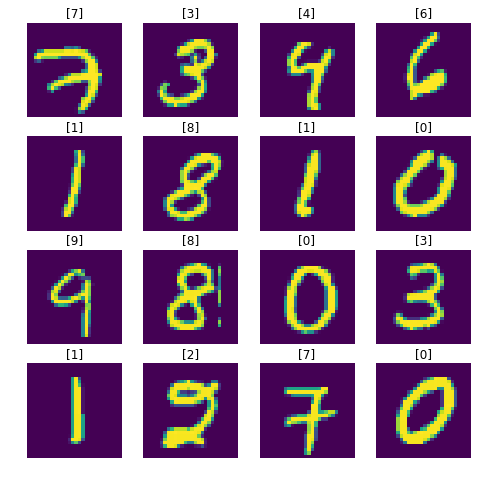

In [3]:
plt.figure(figsize=(8, 8))

for idx in range(16):
    plt.subplot(4, 4, idx + 1)
    plt.axis('off')
    plt.title('[{}]'.format(np.argmax(mnist.train.labels[idx])))
    plt.imshow(mnist.train.images[idx].reshape((28, 28)))

接下来，定义用于训练的网络，首先定义网络的输入。

这里我们直接使用上面的数据作为输入，所以定义两个placeholder分别用于图像和lable数据，另外，定义一个bool类型的变量用于标识当前网络是否正在训练。

为了让网络更高效的运行，多个数据会被组织成一个batch送入网络，两个placeholder的第一个维度就是batchsize，因为我们这里还没有确定batchsize，所以第一个维度留空。

In [4]:
x = tf.placeholder("float", [None, 784], name='x')
y = tf.placeholder("float", [None, 10], name='y')

因为我们输入的是图片展开后的一维向量，所以第一步就需要先把一维向量还原为二维的图片。

In [5]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

接下来，我们定义第一个卷积层，使用6个5X5的卷积核对输入数据进行卷积，
padding方式选择valid，所以输出数据的宽高变为24x24,但是深度已经从原来的1变成了6。
本层卷积的激活函数为relu。

In [6]:
with tf.name_scope('conv1'):
    C1 = tf.contrib.slim.conv2d(
        x_image, 6, [5, 5], padding='VALID', activation_fn=tf.nn.relu)

接下来进行stride为2的最大池化，池化后，输出深度不变，但是长宽减半，所以输出变成了12x12,深度6.

In [7]:
with tf.name_scope('pool1'):
    S2 = tf.contrib.slim.max_pool2d(C1, [2, 2], stride=[2, 2], padding='VALID')

接下来，我们定义第二个卷积层，使用16个5X5的卷积核对输入数据进行卷积，
padding方式还是选择valid，输出8x8,深度为16，本层卷积的激活函数为relu。

In [8]:
with tf.name_scope('conv2'):
    C3 = tf.contrib.slim.conv2d(
        S2, 16, [5, 5], padding='VALID', activation_fn=tf.nn.relu)

再进行一次stride为2的最大池化，输出为4x4,深度16。

In [9]:
with tf.name_scope('pool2'):
    S4 = tf.contrib.slim.max_pool2d(C3, [2, 2], stride=[2, 2], padding='VALID')

池化后的数据是3维的，这里做一个拉平的操作，将3维数据展开到1维，然后送入两层全连接，全连接隐层中神经元个数分别为120，84。

In [10]:
with tf.name_scope('fc1'):
    S4_flat = tf.contrib.slim.flatten(S4)
    C5 = tf.contrib.slim.fully_connected(
        S4_flat, 120, activation_fn=tf.nn.relu)

with tf.name_scope('fc2'):
    F6 = tf.contrib.slim.fully_connected(C5, 84, activation_fn=tf.nn.relu)

Instructions for updating:
Use keras.layers.flatten instead.


###### 对特征添加一个0.6的dropout，以40%的概率丢弃特征中的某些数据，
这样可以提高网络的推广能力，减少过拟合的可能性。

需要注意的是，dropout仅在训练的时候使用，验证的时候，需要关闭dropout，
所以验证时候的keep_prob是1.0。

dropout的输出最终送入一个隐层为10的全连接层，这个全连接层即为最后的分类器。

In [11]:
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(name='keep_prob', dtype=tf.float32)
    F6_drop = tf.nn.dropout(F6, keep_prob)

with tf.name_scope('fc3'):
    logits = tf.contrib.slim.fully_connected(F6_drop, 10, activation_fn=None)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


接下来定义loss和用于优化网络的优化器。loss计算使用了sparse_softmax_cross_entropy_with_logits,
这样做的好处是labels可以不用手动做one_hot省了一些麻烦。这里使用了sgd优化器，学习率为0.3。

>试试看，增大减小学习率，换个优化器再进行训练会发生什么。

In [12]:
cross_entropy_loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

l2_loss = tf.add_n([
    tf.nn.l2_loss(w)
    for w in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
])

for w in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
    print(w.name)
    tf.summary.histogram(w.name, w)
    
total_loss = cross_entropy_loss + 7e-5 * l2_loss
tf.summary.scalar('cross_entropy_loss', cross_entropy_loss)
tf.summary.scalar('l2_loss', l2_loss)
tf.summary.scalar('total_loss', total_loss)

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=0.3).minimize(total_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Conv/weights:0
INFO:tensorflow:Summary name Conv/weights:0 is illegal; using Conv/weights_0 instead.
Conv/biases:0
INFO:tensorflow:Summary name Conv/biases:0 is illegal; using Conv/biases_0 instead.
Conv_1/weights:0
INFO:tensorflow:Summary name Conv_1/weights:0 is illegal; using Conv_1/weights_0 instead.
Conv_1/biases:0
INFO:tensorflow:Summary name Conv_1/biases:0 is illegal; using Conv_1/biases_0 instead.
fully_connected/weights:0
INFO:tensorflow:Summary name fully_connected/weights:0 is illegal; using fully_connected/weights_0 instead.
fully_connected/biases:0
INFO:tensorflow:Summary name fully_connected/biases:0 is illegal; using fully_connected/biases_0 instead.
fully_connected_1/weights:0
INFO:tensorflow:Summary name fully_connected_1/weights:0 is illegal; using fully_connected_1/weights_0 ins

需要注意的是，上面的网络，最后输出的是未经softmax的原始logits，而不是概率分布，
要想看到概率分布，还需要做一下softmax。

将输出的结果与正确结果进行对比，即可得到我们的网络输出结果的准确率。

In [13]:
pred = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

saver用于保存或恢复训练的模型。

In [14]:
batch_size = 100
trainig_step = 1100

saver = tf.train.Saver()

以上定义的所有操作，均为计算图，也就是仅仅是定义了网络的结构，实际需要运行的话，还需要创建一个session，并将数据填入网络中。

In [15]:
merged = tf.summary.merge_all()
with tf.Session() as sess:

    writer = tf.summary.FileWriter("logs/", sess.graph)

    sess.run(tf.global_variables_initializer())

    #定义验证集与测试集
    validate_data = {
        x: mnist.validation.images,
        y: mnist.validation.labels,
        keep_prob: 1.0
    }
    test_data = {x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}

    for i in range(trainig_step):
        xs, ys = mnist.train.next_batch(batch_size)
        _, loss, rs = sess.run(
            [optimizer, cross_entropy_loss, merged],
            feed_dict={
                x: xs,
                y: ys,
                keep_prob: 0.6
            })
        writer.add_summary(rs, i)

        #每100次训练打印一次损失值与验证准确率
        if i > 0 and i % 100 == 0:
            validate_accuracy = sess.run(accuracy, feed_dict=validate_data)
            print(
                "after %d training steps, the loss is %g, the validation accuracy is %g"
                % (i, loss, validate_accuracy))
            saver.save(sess, './model.ckpt', global_step=i)

    print("the training is finish!")
    #最终的测试准确率
    acc = sess.run(accuracy, feed_dict=test_data)
    print("the test accuarcy is:", acc)

after 100 training steps, the loss is 0.387012, the validation accuracy is 0.9134
after 200 training steps, the loss is 0.182484, the validation accuracy is 0.951
after 300 training steps, the loss is 0.235249, the validation accuracy is 0.9566
after 400 training steps, the loss is 0.104088, the validation accuracy is 0.97
after 500 training steps, the loss is 0.0789902, the validation accuracy is 0.974
after 600 training steps, the loss is 0.0646905, the validation accuracy is 0.9748
Instructions for updating:
Use standard file APIs to delete files with this prefix.
after 700 training steps, the loss is 0.0738863, the validation accuracy is 0.979
after 800 training steps, the loss is 0.0600565, the validation accuracy is 0.9796
after 900 training steps, the loss is 0.0968796, the validation accuracy is 0.9776
after 1000 training steps, the loss is 0.230907, the validation accuracy is 0.9746
the training is finish!
the test accuarcy is: 0.9833


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt-1000
1.0


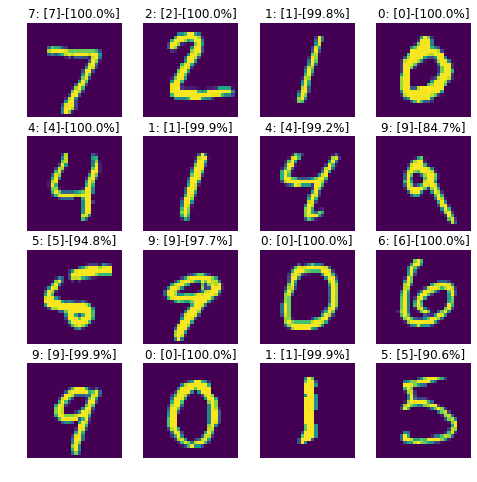

In [16]:
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('./')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        final_pred, acc = sess.run(
            [pred, accuracy],
            feed_dict={
                x: mnist.test.images[:16],
                y: mnist.test.labels[:16],
                keep_prob: 1.0
            })
        orders = np.argsort(final_pred)
        plt.figure(figsize=(8, 8))
        print(acc)
        for idx in range(16):
            order = orders[idx, :][-1]
            prob = final_pred[idx, :][order]
            plt.subplot(4, 4, idx + 1)
            plt.axis('off')
            plt.title('{}: [{}]-[{:.1f}%]'.format(
                np.argmax(mnist.test.labels[idx]), order, prob * 100))
            plt.imshow(mnist.test.images[idx].reshape((28, 28)))

    else:
        pass